In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# load standard modules/libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# load special modules/libraries
import os
import warnings
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter
import string
import re
from tqdm  import tqdm

# load pytorch modules/libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader

from sklearn.metrics import f1_score, roc_auc_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\galloul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading and Sampling the Dataset

In [3]:
# load dataset
raw_df = pd.read_csv("../data/processed_en_dataset.csv")

# Subsample 2500 samples for each class where success == 1 and success == 0
df = pd.concat([
    raw_df[raw_df['success'] == 1].sample(n=len(raw_df[raw_df['success'] == 1]), random_state=42),
    raw_df[raw_df['success'] == 0].sample(n=len(raw_df[raw_df['success'] == 1]), random_state=42)
], ignore_index=True)

# Display class distribution
class_distribution = df['success'].value_counts()
print("Class Distribution:")
print(class_distribution)

# process into data and labels
X = df['Description'].values
y = df['success'].values

Class Distribution:
success
1    5184
0    5184
Name: count, dtype: int64


In [4]:
y

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

# Dataset Preprocessing

In [5]:
def preprocess_string(str1):
    # remove all non-word characters excluding number and letters
    str1= re.sub(r"[^\w\s]",'',str1)
    # remove all whitespace with no space
    str1= re.sub(r"\s",'',str1)
    # replace digits with no space
    str1= re.sub(r"\d",'',str1)
    return str1

def preprocess_sentence(sen1):
    word_list=[]
    stop_word = set(stopwords.words("english"))
    for word in sen1.lower().split():
        word = preprocess_string(word)
        if word not in stop_word and word!='':
            word_list.append(word)
    return word_list

def get_stoi(data):
    word_list=[]
    for review in data:
        word_list.extend(preprocess_sentence(review))
    corpus = Counter(word_list)
    print(corpus.get)
    # sorting on the basis of most common words
    corpus_ =sorted(corpus,key= corpus.get,reverse=True)[:10000] # most popular 10k words 
    # creating a dict
    stoi =  {ch:i+1 for i,ch in enumerate(corpus_)}
    return stoi

def tokenize(data, labels, stoi):
    # tokenize
    data_encoded = []
    for review in data:
        data_encoded.append([stoi[word] for word in preprocess_sentence(review)
                                     if word in stoi.keys()])

    labels_encoded = labels

    return np.array(data_encoded), np.array(labels_encoded)

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review)!=0:
            features[ii, -len(review):] = np.array(review)[:seq_len]

    return features

# Data Splitting

In [6]:
# TO BE COMPLETED
# Split the dataset into train, valid, and test (60-20-20 split)
train_data, temp_data, train_labels, temp_labels = train_test_split(X, y, test_size=0.2, random_state=42)
valid_data, test_data, valid_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

In [7]:
sum(test_labels == 1)

540

In [8]:
# Get vocabulary and convert words to indices
stoi = get_stoi(train_data)

# Tokenize the data
train_data_encoded, train_labels_encoded = tokenize(train_data, train_labels, stoi)
valid_data_encoded, valid_labels_encoded = tokenize(valid_data, valid_labels, stoi)
test_data_encoded, test_labels_encoded = tokenize(test_data, test_labels, stoi)

# Padding
seq_len = 16
train_data_padded = padding_(train_data_encoded, seq_len)
valid_data_padded = padding_(valid_data_encoded, seq_len)
test_data_padded = padding_(test_data_encoded, seq_len)

<built-in method get of Counter object at 0x0000018749872B10>


C:\Users\galloul\AppData\Local\Temp\ipykernel_13332\599508824.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)


In [9]:
# TO BE COMPLETED
# Convert numpy arrays to PyTorch tensors
train_data_tensor = torch.tensor(train_data_padded)
valid_data_tensor = torch.tensor(valid_data_padded)
test_data_tensor = torch.tensor(test_data_padded)

train_labels_tensor = torch.tensor(train_labels_encoded)
valid_labels_tensor = torch.tensor(valid_labels_encoded)
test_labels_tensor = torch.tensor(test_labels_encoded)

# Create TensorDatasets
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
valid_dataset = TensorDataset(valid_data_tensor, valid_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Test the DataLoader
for batch in train_loader:
    data_batch, label_batch = batch
    print("Data Batch Shape:", data_batch.shape)
    print("Label Batch Shape:", label_batch.shape)
    break

Data Batch Shape: torch.Size([16, 16])
Label Batch Shape: torch.Size([16])


In [10]:
for (x, y) in test_loader:
    print(len(y[y==1])/len(y))

0.5
0.625
0.375
0.375
0.625
0.5625
0.375
0.4375
0.5
0.625
0.5
0.4375
0.5
0.5
0.4375
0.4375
0.375
0.6875
0.5
0.4375
0.6875
0.5
0.4375
0.4375
0.4375
0.4375
0.5
0.25
0.5625
0.75
0.25
0.625
0.25
0.375
0.8125
0.625
0.75
0.5625
0.625
0.4375
0.625
0.375
0.3125
0.3125
0.625
0.5
0.5625
0.5625
0.6875
0.3125
0.75
0.4375
0.875
0.8125
0.625
0.4375
0.625
0.625
0.375
0.75
0.4375
0.5625
0.3125
0.6875
0.5384615384615384


In [11]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # RNN layer (you can choose between different types of RNNs like LSTM, GRU)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden):
        # Input x is expected to be a LongTensor of shape (batch_size, sequence_length)

        # Embedding layer
        embedded = self.embedding(x)

        # RNN layer
        output, _ = self.rnn(embedded, hidden)

        # Only take the output from the last time step
        output = output[:, -1, :]

        # Fully connected layer
        output = self.fc(output)

        return output.squeeze(), hidden

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as FF

# Define your sequence classification model
class BaselineModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pretrained_embedding=None, freeze_embedding=True):
        super(BaselineModel, self).__init__()

        # Embedding layer
        if pretrained_embedding is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=freeze_embedding)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Linear layer
        self.linear1 = nn.Linear(embedding_dim, 1)
        
    def forward(self, x):
        embedded = self.embedding(x)
        # Assuming x is a tensor representing the sequence, you may need to adjust accordingly

        # Average pooling along the sequence dimension
        pooled = embedded.mean(dim=1)

        # Linear layer
        output = self.linear1(pooled)
        
        return output.squeeze()


# Training the Logistic Regression Model

Epoch 1/100,                  Training Loss: 0.6951, Training Accuracy: 50.06%                  Training F1: 0.0121, Training AUC: 50.00%                  Validation Loss: 0.6931, Validation Accuracy: 50.18%                  Validation F1: 0.0412, Validation AUC: 51.78%
Epoch 2/100,                  Training Loss: 0.6936, Training Accuracy: 50.20%                  Training F1: 0.2170, Training AUC: 50.71%                  Validation Loss: 0.6923, Validation Accuracy: 53.23%                  Validation F1: 0.2988, Validation AUC: 52.76%
Epoch 3/100,                  Training Loss: 0.6930, Training Accuracy: 50.94%                  Training F1: 0.3349, Training AUC: 51.56%                  Validation Loss: 0.6920, Validation Accuracy: 52.92%                  Validation F1: 0.3435, Validation AUC: 52.70%
Epoch 4/100,                  Training Loss: 0.6925, Training Accuracy: 51.71%                  Training F1: 0.4189, Training AUC: 52.75%                  Validation Loss: 0.6917, Validat

Epoch 32/100,                  Training Loss: 0.6850, Training Accuracy: 56.78%                  Training F1: 0.5210, Training AUC: 58.76%                  Validation Loss: 0.6875, Validation Accuracy: 55.30%                  Validation F1: 0.5360, Validation AUC: 57.34%
Epoch 33/100,                  Training Loss: 0.6850, Training Accuracy: 56.42%                  Training F1: 0.5390, Training AUC: 58.54%                  Validation Loss: 0.6875, Validation Accuracy: 55.75%                  Validation F1: 0.5069, Validation AUC: 57.40%
Epoch 34/100,                  Training Loss: 0.6849, Training Accuracy: 56.59%                  Training F1: 0.5345, Training AUC: 58.88%                  Validation Loss: 0.6874, Validation Accuracy: 55.68%                  Validation F1: 0.5196, Validation AUC: 57.25%
Epoch 35/100,                  Training Loss: 0.6846, Training Accuracy: 56.78%                  Training F1: 0.5267, Training AUC: 59.02%                  Validation Loss: 0.6873, Val

C:\Users\galloul\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 44/100,                  Training Loss: 0.6834, Training Accuracy: 56.92%                  Training F1: 0.5418, Training AUC: 59.39%                  Validation Loss: 0.6868, Validation Accuracy: 55.68%                  Validation F1: 0.5467, Validation AUC: 56.86%
Epoch 45/100,                  Training Loss: 0.6832, Training Accuracy: 56.94%                  Training F1: 0.5606, Training AUC: 59.11%                  Validation Loss: 0.6867, Validation Accuracy: 55.87%                  Validation F1: 0.5404, Validation AUC: 56.86%
Epoch 46/100,                  Training Loss: 0.6830, Training Accuracy: 56.57%                  Training F1: 0.5635, Training AUC: 59.41%                  Validation Loss: 0.6867, Validation Accuracy: 55.97%                  Validation F1: 0.5319, Validation AUC: 57.05%
Epoch 47/100,                  Training Loss: 0.6828, Training Accuracy: 56.98%                  Training F1: 0.5477, Training AUC: 59.58%                  Validation Loss: 0.6866, Val

Epoch 75/100,                  Training Loss: 0.6799, Training Accuracy: 57.32%                  Training F1: 0.5665, Training AUC: 60.32%                  Validation Loss: 0.6856, Validation Accuracy: 55.61%                  Validation F1: 0.5532, Validation AUC: 56.98%
Epoch 76/100,                  Training Loss: 0.6799, Training Accuracy: 57.39%                  Training F1: 0.5707, Training AUC: 60.61%                  Validation Loss: 0.6857, Validation Accuracy: 55.80%                  Validation F1: 0.5610, Validation AUC: 56.91%
Epoch 77/100,                  Training Loss: 0.6799, Training Accuracy: 57.25%                  Training F1: 0.5727, Training AUC: 60.59%                  Validation Loss: 0.6856, Validation Accuracy: 55.70%                  Validation F1: 0.5501, Validation AUC: 56.81%
Epoch 78/100,                  Training Loss: 0.6799, Training Accuracy: 57.19%                  Training F1: 0.5816, Training AUC: 60.35%                  Validation Loss: 0.6855, Val

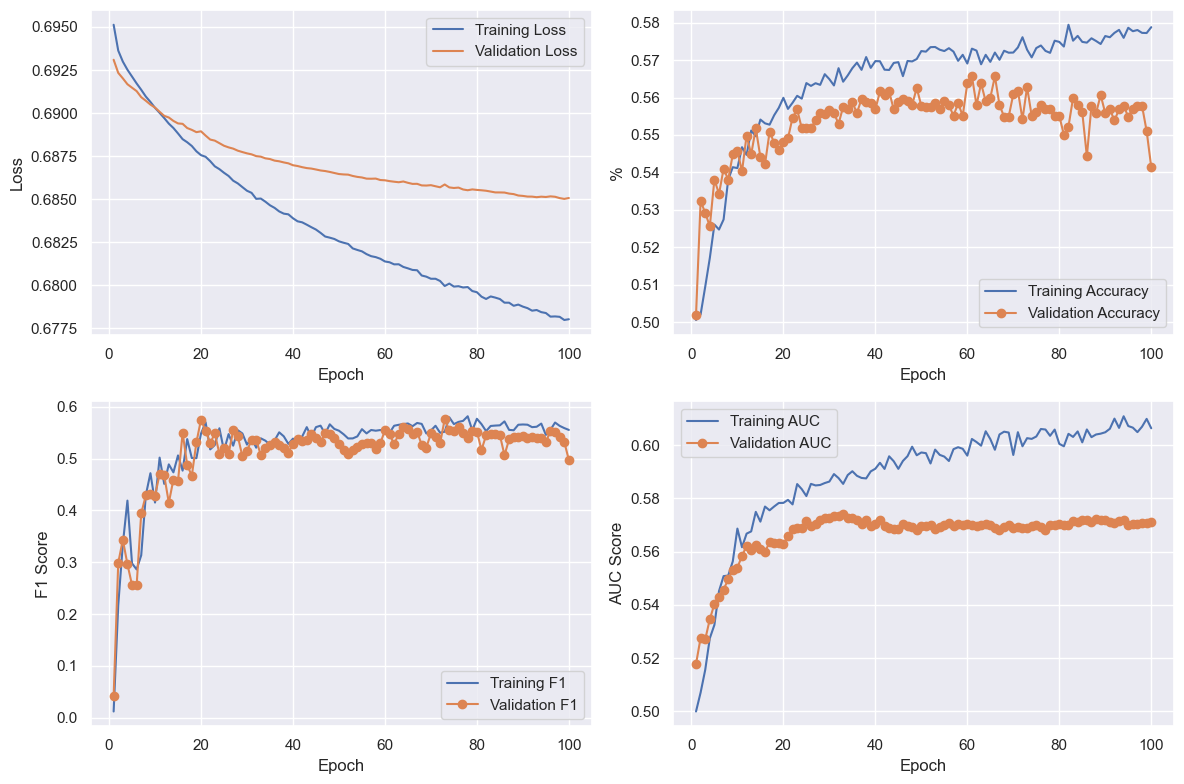

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as FF
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchmetrics.functional.classification as F

# Your code here

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

sns.set()

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=100, val_interval=10):
    
    model.train()
    losses = []
    accuracies = []
    f1_scores = []
    auc_scores = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    val_auc_scores = []
    
    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        accuracy = 0.0
        f1_score = 0.0
        auc_score = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y.float())
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            # Update Accuracy metric
            outputs = FF.sigmoid(outputs)
            accuracy += F.binary_accuracy(outputs, y)
            f1_score += F.binary_f1_score(outputs, y)
            auc_score += F.binary_auroc(outputs, y.type(torch.int))
            
        average_loss = total_loss / len(train_loader)
        average_accuracy = accuracy / len(train_loader)
        average_f1 = f1_score / len(train_loader)
        average_auc = auc_score / len(train_loader)
        
        losses.append(average_loss)
        accuracies.append(average_accuracy.item())
        f1_scores.append(average_f1.item())
        auc_scores.append(average_auc.item())
        
        if epoch % val_interval == 0:
            val_loss, val_accuracy, val_f1, val_auc = validate(model, val_loader, criterion, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy.item())
            val_f1_scores.append(val_f1.item())
            val_auc_scores.append(val_auc.item())
            
            print(f'Epoch {epoch}/{num_epochs},\
                  Training Loss: {average_loss:.4f}, Training Accuracy: {average_accuracy:.2%}\
                  Training F1: {average_f1:.4f}, Training AUC: {average_auc:.2%}\
                  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}\
                  Validation F1: {val_f1:.4f}, Validation AUC: {val_auc:.2%}')            
                  
        
        else:
            print(f'Epoch {epoch}/{num_epochs},\
                  Training Loss: {average_loss:.4f}, Training Accuracy: {average_accuracy:.2%}\
                  Training F1: {average_f1:.4f}, Training AUC: {average_auc:.2%}')

    
    epochs = range(1, len(losses) + 1)
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot training and validation losses
    axs[0, 0].plot(epochs, losses, label='Training Loss')
    axs[0, 0].plot(range(val_interval, len(val_losses) * val_interval + 1, val_interval), val_losses, label='Validation Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # Plot validation accuracy
    axs[0, 1].plot(epochs, accuracies, label='Training Accuracy')
    axs[0, 1].plot(range(val_interval, len(val_accuracies) * val_interval + 1, val_interval), val_accuracies, label='Validation Accuracy', marker='o')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('%')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Plot training and validation F1 scores
    axs[1, 0].plot(epochs, f1_scores, label='Training F1')
    axs[1, 0].plot(range(val_interval, len(val_accuracies) * val_interval + 1, val_interval), val_f1_scores, label='Validation F1', marker='o')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('F1 Score')
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # Plot training and validation AUC scores
    axs[1, 1].plot(epochs, auc_scores, label='Training AUC')
    axs[1, 1].plot(range(val_interval, len(val_accuracies) * val_interval + 1, val_interval), val_auc_scores, label='Validation AUC', marker='o')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('AUC Score')
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    accuracy = 0.0
    f1_score = 0.0
    auc_score = 0.0
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            
            outputs = model(x)
            loss = criterion(outputs, y.float())
            total_loss += loss.item()
            # Update Accuracy metric
            outputs = FF.sigmoid(outputs)
            accuracy += F.binary_accuracy(outputs, y)
            f1_score += F.binary_f1_score(outputs, y)
            auc_score += F.binary_auroc(outputs, y.type(torch.int))
            
        average_loss = total_loss / len(val_loader)
        average_accuracy = accuracy / len(val_loader)
        average_f1 = f1_score / len(val_loader)
        average_auc = auc_score / len(val_loader)
    return average_loss, average_accuracy, average_f1, average_auc

# model, optimizer, and loss criterion
weights = df["success"].value_counts(normalize=True).values
embedding_dim = 300  
lr = 1e-4
num_epochs = 100
glove = GloVe(name='6B', dim=300)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineModel(len(stoi)+1, embedding_dim, pretrained_embedding=glove.vectors)
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.BCEWithLogitsLoss()
#
model.to(device)
train(model, train_loader, valid_loader, criterion, optimizer, scheduler, device, num_epochs=num_epochs, val_interval=1)

In [23]:
# logistic regression performance on test set
validate(model, test_loader, criterion=criterion, device=device)

(0.6857434327785785,
 tensor(0.5374, device='cuda:0'),
 tensor(0.5150, device='cuda:0'),
 tensor(0.5616, device='cuda:0'))

# Training the LSTM Model

Epoch 1/100,                  Training Loss: 0.6948, Training Accuracy: 50.26%                  Training F1: 0.5500, Training AUC: 50.24%                  Validation Loss: 0.6957, Validation Accuracy: 50.21%                  Validation F1: 0.5510, Validation AUC: 49.29%
Epoch 2/100,                  Training Loss: 0.6943, Training Accuracy: 50.37%                  Training F1: 0.5508, Training AUC: 50.44%                  Validation Loss: 0.6955, Validation Accuracy: 50.78%                  Validation F1: 0.5535, Validation AUC: 49.43%
Epoch 3/100,                  Training Loss: 0.6939, Training Accuracy: 50.66%                  Training F1: 0.5510, Training AUC: 50.87%                  Validation Loss: 0.6954, Validation Accuracy: 50.78%                  Validation F1: 0.5522, Validation AUC: 49.40%
Epoch 4/100,                  Training Loss: 0.6935, Training Accuracy: 51.03%                  Training F1: 0.5535, Training AUC: 51.15%                  Validation Loss: 0.6953, Validat

C:\Users\galloul\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 12/100,                  Training Loss: 0.6904, Training Accuracy: 53.18%                  Training F1: 0.5571, Training AUC: 54.53%                  Validation Loss: 0.6942, Validation Accuracy: 51.77%                  Validation F1: 0.5484, Validation AUC: 51.12%
Epoch 13/100,                  Training Loss: 0.6900, Training Accuracy: 53.53%                  Training F1: 0.5574, Training AUC: 54.83%                  Validation Loss: 0.6942, Validation Accuracy: 51.29%                  Validation F1: 0.5400, Validation AUC: 50.96%
Epoch 14/100,                  Training Loss: 0.6897, Training Accuracy: 53.71%                  Training F1: 0.5577, Training AUC: 55.30%                  Validation Loss: 0.6940, Validation Accuracy: 51.58%                  Validation F1: 0.5390, Validation AUC: 50.98%
Epoch 15/100,                  Training Loss: 0.6892, Training Accuracy: 53.95%                  Training F1: 0.5542, Training AUC: 55.35%                  Validation Loss: 0.6939, Val

C:\Users\galloul\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 16/100,                  Training Loss: 0.6889, Training Accuracy: 54.15%                  Training F1: 0.5560, Training AUC: 56.31%                  Validation Loss: 0.6938, Validation Accuracy: 51.67%                  Validation F1: 0.5385, Validation AUC: 51.01%
Epoch 17/100,                  Training Loss: 0.6886, Training Accuracy: 54.42%                  Training F1: 0.5574, Training AUC: 56.61%                  Validation Loss: 0.6937, Validation Accuracy: 52.06%                  Validation F1: 0.5395, Validation AUC: 51.13%
Epoch 18/100,                  Training Loss: 0.6881, Training Accuracy: 54.69%                  Training F1: 0.5586, Training AUC: 56.80%                  Validation Loss: 0.6937, Validation Accuracy: 52.15%                  Validation F1: 0.5390, Validation AUC: 51.08%
Epoch 19/100,                  Training Loss: 0.6878, Training Accuracy: 55.03%                  Training F1: 0.5633, Training AUC: 57.72%                  Validation Loss: 0.6935, Val

Epoch 47/100,                  Training Loss: 0.6768, Training Accuracy: 61.74%                  Training F1: 0.6051, Training AUC: 66.11%                  Validation Loss: 0.6912, Validation Accuracy: 52.94%                  Validation F1: 0.5123, Validation AUC: 54.00%
Epoch 48/100,                  Training Loss: 0.6765, Training Accuracy: 61.83%                  Training F1: 0.6045, Training AUC: 66.20%                  Validation Loss: 0.6912, Validation Accuracy: 52.75%                  Validation F1: 0.5069, Validation AUC: 53.99%
Epoch 49/100,                  Training Loss: 0.6760, Training Accuracy: 62.01%                  Training F1: 0.6079, Training AUC: 66.30%                  Validation Loss: 0.6911, Validation Accuracy: 52.75%                  Validation F1: 0.5070, Validation AUC: 54.04%
Epoch 50/100,                  Training Loss: 0.6755, Training Accuracy: 62.11%                  Training F1: 0.6057, Training AUC: 67.05%                  Validation Loss: 0.6910, Val

Epoch 78/100,                  Training Loss: 0.6609, Training Accuracy: 65.43%                  Training F1: 0.6261, Training AUC: 71.01%                  Validation Loss: 0.6893, Validation Accuracy: 54.41%                  Validation F1: 0.5076, Validation AUC: 55.15%
Epoch 79/100,                  Training Loss: 0.6602, Training Accuracy: 65.50%                  Training F1: 0.6262, Training AUC: 71.29%                  Validation Loss: 0.6892, Validation Accuracy: 54.70%                  Validation F1: 0.5097, Validation AUC: 55.12%
Epoch 80/100,                  Training Loss: 0.6595, Training Accuracy: 65.61%                  Training F1: 0.6251, Training AUC: 71.13%                  Validation Loss: 0.6891, Validation Accuracy: 55.08%                  Validation F1: 0.5129, Validation AUC: 55.10%
Epoch 81/100,                  Training Loss: 0.6589, Training Accuracy: 65.74%                  Training F1: 0.6291, Training AUC: 71.98%                  Validation Loss: 0.6891, Val

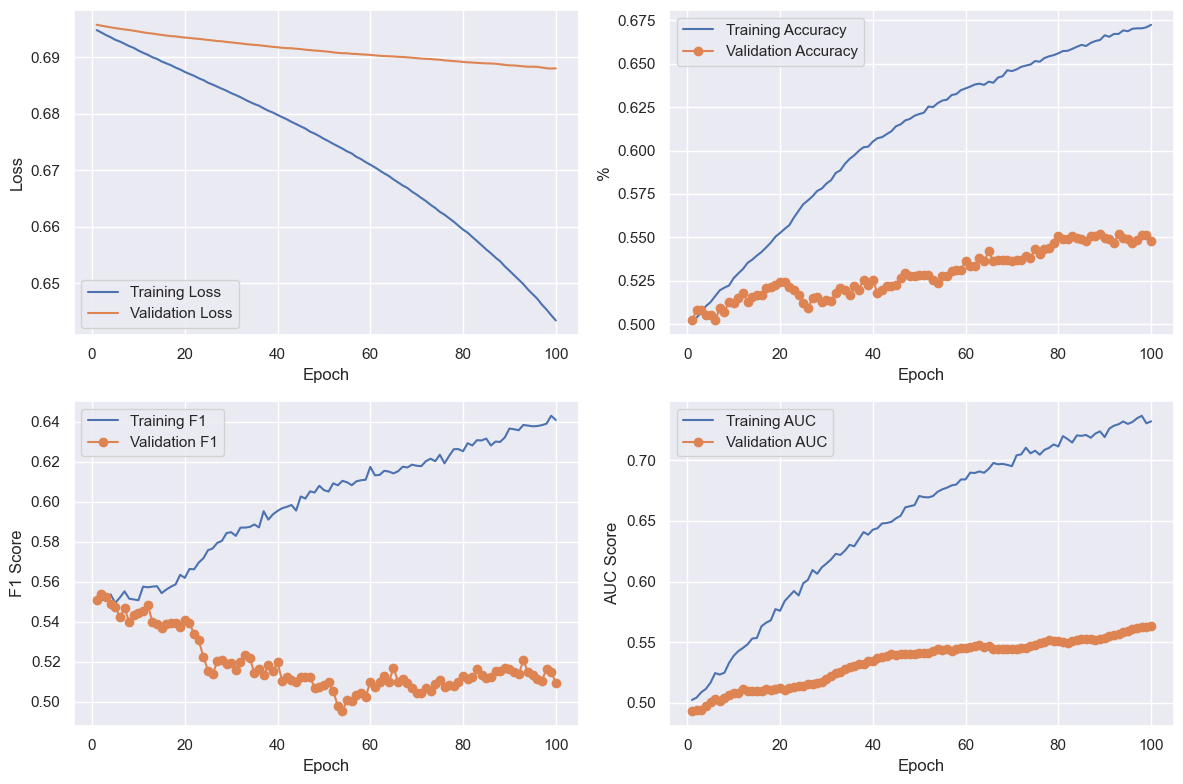

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as FF
# Your code here

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

sns.set()

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=100, val_interval=10):
    
    model.train()
    losses = []
    accuracies = []
    f1_scores = []
    auc_scores = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    val_auc_scores = []
    
    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        accuracy = 0.0
        f1_score = 0.0
        auc_score = 0.0
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            h = None
            outputs, _ = model(x, h)
            loss = criterion(outputs, y.float())
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            # Update Accuracy metric
            outputs = FF.sigmoid(outputs)
            accuracy += F.binary_accuracy(outputs, y)
            f1_score += F.binary_f1_score(outputs, y)
            auc_score += F.binary_auroc(outputs, y.type(torch.int))
            
        average_loss = total_loss / len(train_loader)
        average_accuracy = accuracy / len(train_loader)
        average_f1 = f1_score / len(train_loader)
        average_auc = auc_score / len(train_loader)
        
        losses.append(average_loss)
        accuracies.append(average_accuracy.item())
        f1_scores.append(average_f1.item())
        auc_scores.append(average_auc.item())
        
        if epoch % val_interval == 0:
            val_loss, val_accuracy, val_f1, val_auc = validate(model, val_loader, criterion, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy.item())
            val_f1_scores.append(val_f1.item())
            val_auc_scores.append(val_auc.item())
            
            print(f'Epoch {epoch}/{num_epochs},\
                  Training Loss: {average_loss:.4f}, Training Accuracy: {average_accuracy:.2%}\
                  Training F1: {average_f1:.4f}, Training AUC: {average_auc:.2%}\
                  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}\
                  Validation F1: {val_f1:.4f}, Validation AUC: {val_auc:.2%}')            
                  
        
        else:
            print(f'Epoch {epoch}/{num_epochs},\
                  Training Loss: {average_loss:.4f}, Training Accuracy: {average_accuracy:.2%}\
                  Training F1: {average_f1:.4f}, Training AUC: {average_auc:.2%}')

    
    epochs = range(1, len(losses) + 1)
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot training and validation losses
    axs[0, 0].plot(epochs, losses, label='Training Loss')
    axs[0, 0].plot(range(val_interval, len(val_losses) * val_interval + 1, val_interval), val_losses, label='Validation Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # Plot validation accuracy
    axs[0, 1].plot(epochs, accuracies, label='Training Accuracy')
    axs[0, 1].plot(range(val_interval, len(val_accuracies) * val_interval + 1, val_interval), val_accuracies, label='Validation Accuracy', marker='o')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('%')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Plot training and validation F1 scores
    axs[1, 0].plot(epochs, f1_scores, label='Training F1')
    axs[1, 0].plot(range(val_interval, len(val_accuracies) * val_interval + 1, val_interval), val_f1_scores, label='Validation F1', marker='o')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('F1 Score')
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # Plot training and validation AUC scores
    axs[1, 1].plot(epochs, auc_scores, label='Training AUC')
    axs[1, 1].plot(range(val_interval, len(val_accuracies) * val_interval + 1, val_interval), val_auc_scores, label='Validation AUC', marker='o')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('AUC Score')
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    accuracy = 0.0
    f1_score = 0.0
    auc_score = 0.0
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            
            outputs, _ = model(x, None)
            loss = criterion(outputs, y.float())
            total_loss += loss.item()
            # Update Accuracy metric
            outputs = FF.sigmoid(outputs)
            accuracy += F.binary_accuracy(outputs, y)
            f1_score += F.binary_f1_score(outputs, y)
            auc_score += F.binary_auroc(outputs, y.type(torch.int))
            
        average_loss = total_loss / len(val_loader)
        average_accuracy = accuracy / len(val_loader)
        average_f1 = f1_score / len(val_loader)
        average_auc = auc_score / len(val_loader)
    return average_loss, average_accuracy, average_f1, average_auc

# model, optimizer, and loss criterion
weights = df["success"].value_counts(normalize=True).values
embedding_dim = 300  
lr = 7e-6
num_epochs = 100

glove = GloVe(name='6B', dim=300)
vocab_size = len(stoi) + 1 # Specify your vocabulary size
embed_size = 256 # Specify the embedding size
hidden_size = 128 # Specify the hidden size for the LSTM
output_size =  2# Specify the output size (number of classes)
model = SentimentRNN(vocab_size, embed_size, hidden_size, output_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = BaselineModel(len(stoi)+1, embedding_dim, pretrained_embedding=glove.vectors)
model = SentimentRNN(len(stoi)+1, embedding_dim=embed_size, hidden_dim=hidden_size, output_dim=1)

optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.BCEWithLogitsLoss()
#
model.to(device)
train(model, train_loader, valid_loader, criterion, optimizer, scheduler, device, num_epochs=num_epochs, val_interval=1)

In [35]:
# LSTM Performance on test set
validate(model, test_loader, criterion=criterion, device=device)

(0.6989337618534381,
 tensor(0.5025, device='cuda:0'),
 tensor(0.4859, device='cuda:0'),
 tensor(0.5230, device='cuda:0'))

In [ ]:
# from sklearn.metrics import f1_score, roc_auc_score
# import seaborn as sns
# from torchmetrics.classification import AUROC

# auc_metric = AUROC(task='binary')

# # Modify the get_metrics function to compute F1 score and AUC
# def get_metrics(model, data, criterion=nn.CrossEntropyLoss(), mode="train", device="cpu"):
#     correct, total = 0, 0
#     all_preds = []
#     all_labels = []
#     all_probs = []
#     total_loss = 0
#     for inputs, labels in data:
#         inputs, labels = inputs.to(device), labels.to(device)
#         h = None
#         output, _ = model(inputs, h)
#         pred = output.max(1, keepdim=True)[1]
#         correct += pred.eq(labels.view_as(pred)).sum().item()
#         total += labels.shape[0]
#         loss = criterion(output, labels.long())
        
#         all_preds.extend(pred.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())
#         total_loss += loss
        
#         # Get probability scores for the positive class
#         probs = torch.softmax(output, dim=1).detach().cpu().numpy()
#         all_probs.extend(probs)

#     accuracy = correct / total
#     f1 = f1_score(all_labels, all_preds, average='weighted')
#     total_loss /= len(data)

#     # Check if there are at least two unique labels for AUC computation
# #     unique_labels = np.unique(all_labels)
# # #     if len(unique_labels) > 1:
# #     auc = roc_auc_score(all_labels, all_probs, labels=[0, 1])
# #     else:
# #         auc = 0.5  # Set a default value if there's only one class

#     if mode == "train":
#         return accuracy, f1
#     else:
#         return total_loss, accuracy, f1

# # Modify the train_rnn_network function to collect AUC scores
# def train_rnn_network(model, train, valid, num_epochs=20, learning_rate=1e-5, device="cpu"):
#     model.to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     losses, train_acc, valid_acc, train_f1, valid_f1 = [], [], [], [], []
#     epochs = []
#     val_losses = []
#     hidden = None

#     for epoch in range(num_epochs):
#         for inputs, labels in train:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             pred, _ = model(inputs, hidden)
#             loss = criterion(pred, labels.long())
#             loss.backward()
#             optimizer.step()
#         losses.append(float(loss))

#         epoch_train_acc, epoch_train_f1 = get_metrics(model, train_loader, device=device)
#         epoch_valid_loss, epoch_valid_acc, epoch_valid_f1 = get_metrics(model, valid_loader, mode="val", device=device)

#         train_acc.append(epoch_train_acc)
#         valid_acc.append(epoch_valid_acc)
#         train_f1.append(epoch_train_f1)
#         valid_f1.append(epoch_valid_f1)
#         val_losses.append(epoch_valid_loss)
# #         train_auc.append(epoch_train_auc)
# #         valid_auc.append(epoch_valid_auc)

#         epochs.append(epoch)
#         print("Epoch %d; Loss %f; Val Loss %f; Train Acc %f; Val Acc %f; Train F1 %f; Val F1 %f" % (
#               epoch+1, loss, epoch_valid_loss, epoch_train_acc, epoch_valid_acc, epoch_train_f1, epoch_valid_f1))

#     sns.set()
#     # Plotting
#     plt.title("Train vs. Validation Loss")
#     plt.plot(losses, label="Train")
#     plt.plot(val_losses, label="Validation")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.show()

#     plt.title("Train vs. Validation Accuracy")
#     plt.plot(epochs, train_acc, label="Train")
#     plt.plot(epochs, valid_acc, label="Validation")
#     plt.xlabel("Epoch")
#     plt.ylabel("Accuracy")
#     plt.legend(loc='best')
#     plt.show()

#     plt.title("Train vs. Validation F1 Score")
#     plt.plot(epochs, train_f1, label="Train")
#     plt.plot(epochs, valid_f1, label="Validation")
#     plt.xlabel("Epoch")
#     plt.ylabel("F1 Score")
#     plt.legend(loc='best')
#     plt.show()

#     plt.title("Train vs. Validation AUC")
#     plt.plot(epochs, train_auc, label="Train")
#     plt.plot(epochs, valid_auc, label="Validation")
#     plt.xlabel("Epoch")
#     plt.ylabel("AUC")
#     plt.legend(loc='best')
#     plt.show()

# # Rest of the code remains unchanged

# # Train the model with F1 score and AUC
# # train_rnn_network(model, train_loader, valid_loader, num_epochs=10, learning_rate=2e-4, device="cuda")


In [ ]:
# vocab_size = len(stoi) + 1 # Specify your vocabulary size
# embed_size = 100 # Specify the embedding size
# hidden_size = 64 # Specify the hidden size for the LSTM
# output_size =  2# Specify the output size (number of classes)
# model = SentimentRNN(vocab_size, embed_size, hidden_size, output_size)

# train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=2e-4, device="cpu")